In [ ]:
! pip install -q pytorch-lightning
! pip install -q pytorch-lightning-bolts
! pwd

/content


In [ ]:
print(torch.__version__)

1.7.0+cu101


In [ ]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, io
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random


In [ ]:
#TODO !wget 

In [ ]:
import zipfile
with zipfile.ZipFile("Data.zip", 'r') as zip_ref_new:
  zip_ref_new.extractall("data")

import zipfile
with zipfile.ZipFile("face1.zip", 'r') as zip_ref_new:
  zip_ref_new.extractall("data2") 

In [ ]:
# Rozdělení testovacích dat do souborů
dataset = datasets.ImageFolder("data/Data")
dataset2 = datasets.ImageFolder("data2/face")

# Tisk kategorií a datasetu
print(dataset.classes)
print(len(dataset))

# Nastavení transformací nad daty
XX = 244

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(XX),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(XX),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(XX),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Rozdělení testovacích dat
train, val = random_split(dataset, [22000, 7778])
_, test = random_split(dataset2, [0, 981])

# Provedení transformací nad testovacími daty
train.dataset.transform = data_transforms['train']
val.dataset.transform = data_transforms['val']
test.dataset.transform = data_transforms['test']

# Počet testovacích vzorků - batch_size = 10
train_dataloader = DataLoader(train, batch_size=10, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val, batch_size=10, num_workers=2)
test_dataloader = DataLoader(test, batch_size=10, num_workers=2)


print(len(val_dataloader))
print(len(train_dataloader))
print(len(test_dataloader))

class_names = dataset.classes



['angry', 'happy', 'neutral', 'sad']
29778
778
2200
99


# New Section

In [ ]:
def imgshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)

  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [ ]:
def getDataForHistogram(any_dataloader):
  #data_histogram = [0,0,0,0,0,0,0]
  data_histogram = [0,0,0,0]
  for _, classes in any_dataloader:
    for clas in classes:
      data_histogram[clas] = data_histogram[clas] + 1

  return data_histogram

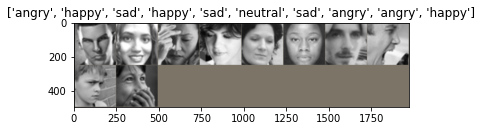

Train - Histogram
Val - Histogram
Test - Histogram


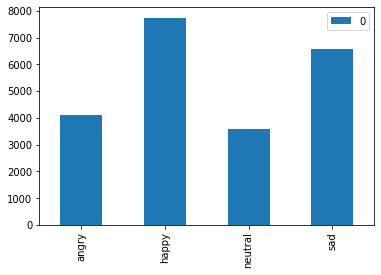

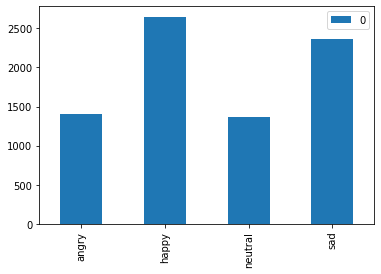

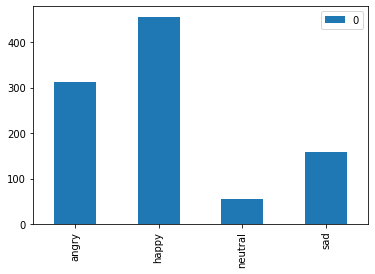

In [ ]:
inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

class_names = dataset.classes
imgshow(out, title=[class_names[x] for x in classes])

import pandas as pd

#columns = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
columns = ['angry', 'happy', 'neutral', 'sad']

# - Tvoří nepěkné názby např: (angry,) - train_count = pd.DataFrame(data=[train_data], columns=[train_dataloader.dataset.dataset.classes])
print("Train - Histogram")
train_count = pd.DataFrame(data=[getDataForHistogram(train_dataloader)], columns = ['angry', 'happy', 'neutral', 'sad'])
train_count.transpose().plot(kind='bar')

print("Val - Histogram")
val_count = pd.DataFrame(data=[getDataForHistogram(val_dataloader)], columns = ['angry', 'happy', 'neutral', 'sad'])
val_count.transpose().plot(kind='bar')

print("Test - Histogram")
test_count = pd.DataFrame(data=[getDataForHistogram(test_dataloader)], columns = ['angry', 'happy', 'neutral', 'sad'])
test_count.transpose().plot(kind='bar')

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

Fri Jan  1 14:30:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
class CweFace(pl.LightningModule):

    def __init__(self, num_target_classes):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        print(num_ftrs)
        print(num_target_classes)
        self.model.fc = nn.Linear(num_ftrs, num_target_classes)
        self.acc = pl.metrics.Accuracy()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # --------------------------
        # REPLACE WITH YOUR OWN
        x, y = batch

        y_hat = self(x)
        
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.acc(y_hat, y), on_step=True, on_epoch=False)

        return loss
        # --------------------------

    def training_epoch_end(self, outs):
        acc = self.acc.compute()
        self.log("train_acc_epoch", acc)

    def validation_step(self, batch, batch_idx):
        # --------------------------
        # REPLACE WITH YOUR OWN 
        x, y = batch

        y_hat = self(x)
        
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc_step', self.acc(y_hat, y), on_step=True, on_epoch=False)
        # --------------------------

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1, momentum=0.9) #1e-3
        return optimizer

model = CweFace(len(class_names))

trainer = pl.Trainer(gpus=1, max_epochs=40)
trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ResNet   | 23.5 M
1 | acc   | Accuracy | 0     
-----------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


2048
4


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/


In [ ]:
!pwd

/content


In [ ]:
loader = transforms.Compose([
        transforms.Resize(XX),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    custom_image = Image.open(image_name).convert('RGB')
    custom_image = loader(custom_image).float()
    custom_image = custom_image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return custom_image.cuda()  #assumes that you're using GPU

 def image_loader_img(image_name):
    """load image, returns cuda tensor"""
    custom_image = Image.open(image_name).convert('RGB')
    custom_image = loader(custom_image).float()
    return custom_image  #assumes that you're using GPU   

image = image_loader("me.jpg")
outputs = model(image)
_, preds = torch.max(outputs, 1)

image_out = image_loader_img("me.jpg")
out = out = torchvision.utils.make_grid(image_out)
imgshow(out,class_names[preds])

tensor([[ 0.1675,  6.6303, -3.4130, -3.4359],
        [ 6.6777, -7.0812, -5.4358,  5.8197],
        [-5.2296, 11.9371, -8.5698,  1.7592],
        [-5.0841,  5.4521, -0.7060,  0.2996],
        [ 1.7070, -5.9494,  2.6781,  1.5332],
        [-4.9262,  7.5496, -1.0962, -1.5987],
        [ 1.2053, -1.0199, -1.0044,  0.7844],
        [ 2.1460, -4.3037, -2.4619,  4.5926],
        [ 1.0959, -3.1397, -0.7637,  2.7962],
        [-4.5548,  8.2457, -4.1621,  0.3567]], device='cuda:0',
       grad_fn=<AddmmBackward>)


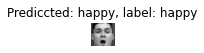

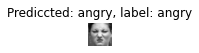

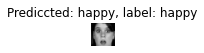

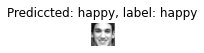

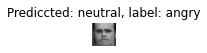

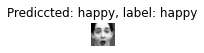

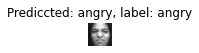

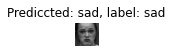

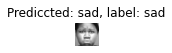

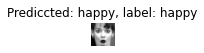

tensor([[ 2.3215, -6.6449,  0.9545,  3.3426],
        [-2.3040,  0.6150,  2.0495, -0.4179],
        [ 6.9027, -7.5225, -6.0747,  6.6558],
        [-2.2561, 10.5407, -3.9383, -4.4490],
        [-4.5788, 15.0264, -7.7402, -2.8029],
        [ 4.2938, -3.9412, -1.7947,  1.4385],
        [-6.6317, 13.0818, -4.1928, -2.3250],
        [ 1.9338, -5.8604, -0.0773,  3.9726],
        [ 2.8259, -4.6962,  1.0191,  0.8109],
        [-6.7274,  9.8943, -1.1572, -2.0611]], device='cuda:0',
       grad_fn=<AddmmBackward>)


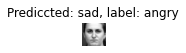

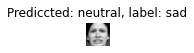

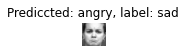

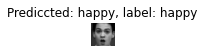

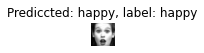

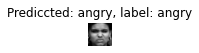

In [ ]:
device = torch.device("cuda")

def vizualize_model(model, num_images=16):
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  for i, (inputs, labels) in enumerate(test_dataloader):
    if bool(random.getrandbits(1)):
      continue

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    print(outputs)
    _, preds = torch.max(outputs, 1)

    for j in range(inputs.size()[0]):
      images_so_far = images_so_far+1
      ax = plt.subplot(num_images//2, 2, images_so_far)
      ax.axis("off")
      ax.set_title("Prediccted: {}, label: {}".format(class_names[preds[j]], class_names[labels[j]]))

      imgshow(inputs.cpu().data[j])

      if images_so_far == num_images:
        return


model.to(device)
vizualize_model(model)

In [ ]:

torch.jit.save(model.to_torchscript(), "model_final_epoch_04.ts")  
#files.download('model_final_epoch_01.pt')

In [ ]:
preds_field = []
true_field = []
q = 0;
# Graphical analytics
for i, data in enumerate(test_dataloader):

        x, y_true = data 
        
        if torch.cuda.is_available():
         x, y_true = x.cuda(), y_true.cuda()
        out = model(x)
        _, preds = torch.max(out, 1)
        for j in range(y_true.size()[0]):
          preds_field.append(preds[j])
          true_field.append(y_true[j])
          #ax = plt.subplot(16//2, 2, 1)
          #ax.axis("off")
          #class_names = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')
          #ax.set_title("Prediccted: {}, label: {}".format(class_names[preds[j]], class_names[y_true[j]]))
          
          #imgshow(inputs.cpu().data[j])

In [ ]:
from pytorch_lightning.metrics import ConfusionMatrix

confmat = ConfusionMatrix(num_classes=4)
target = torch.tensor(true_field)
preds = torch.tensor(preds_field)
confmat(preds, target)

tensor([[163.,  13.,  42.,  94.],
        [  2., 441.,  10.,   3.],
        [  0.,  16.,  34.,   4.],
        [ 14.,  16.,  19., 110.]])

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[163.,  13.,  42.,  94.],
        [  2., 441.,  10.,   3.],
        [  0.,  16.,  34.,   4.],
        [ 14.,  16.,  19., 110.]])


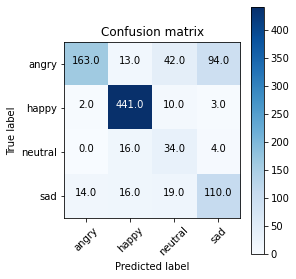

In [ ]:
plt.figure(figsize=(4,4))
plot_confusion_matrix(confmat(preds, target), test_dataloader.dataset.dataset.classes)